In [19]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import joblib


In [20]:
# import dataset from csv file
df = pd.read_csv('../Data/Datos_enriquecidos.csv')
df

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
0,1,2020-06-17,3,1,360.0,1,0,6,2020,25,...,0.0,15.75,16.5,13.720423,108.0,30.0,0.0,13.500,12.0,10.993505
1,1,2020-06-18,33,1,357.0,1,0,6,2020,25,...,0.0,10.50,6.0,13.527749,102.0,30.0,0.0,12.750,12.0,11.535659
2,1,2020-06-19,21,1,324.0,1,0,6,2020,25,...,3.0,18.75,19.5,14.974979,114.0,33.0,0.0,14.250,12.0,13.392429
3,1,2020-06-20,15,1,300.0,1,0,6,2020,25,...,3.0,16.50,15.0,13.304135,120.0,33.0,0.0,15.000,15.0,13.606721
4,1,2020-06-21,0,1,288.0,0,1,6,2020,25,...,3.0,18.00,18.0,12.489996,135.0,33.0,0.0,16.875,18.0,12.205824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31795,50,2022-03-10,3,0,93.0,1,0,3,2022,10,...,0.0,5.25,3.0,6.652067,57.0,15.0,0.0,7.125,7.5,5.055054
31796,50,2022-03-11,0,0,90.0,1,0,3,2022,10,...,3.0,6.00,3.0,6.000000,51.0,15.0,0.0,6.375,4.5,5.180665
31797,50,2022-03-12,9,0,90.0,1,0,3,2022,10,...,0.0,5.25,3.0,6.652067,45.0,15.0,0.0,5.625,3.0,5.655276
31798,50,2022-03-13,0,0,81.0,0,1,3,2022,10,...,0.0,6.75,6.0,6.652067,42.0,15.0,0.0,5.250,3.0,5.257647


In [21]:
# importar ../Data/DatosCicloAprovisionamiento.xlsx
df_ciclo = pd.read_excel('../Data/DatosCicloAprovisionamiento.xlsx')
df_ciclo = df_ciclo.sort_values(by=['sku']).reset_index(drop=True)
df_ciclo = df_ciclo.rename(columns={'sku': 'idSku'})
df_ciclo['ciclo_aprovisionamiento'] = df_ciclo['diasEntrePedidos'] + df_ciclo['diasLeadtime']
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento
0,1,18,2,20
1,2,28,4,32
2,3,28,2,30
3,4,14,2,16
4,5,14,4,18


In [31]:
# create an empty dataframe with columns of df and types of df
df_agg = pd.DataFrame(columns=df.columns)
df_agg = df_agg.astype(df.dtypes.to_dict())
df_agg

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8


In [33]:
skus = df['idSku'].unique()

for s in skus:
    df_s = df[df['idSku'] == s]
    ciclo_s = df_ciclo[df_ciclo['idSku'] == s]['ciclo_aprovisionamiento'].values[0]
    # create a new column for df_s with the sum of the next ciclo_s udsVenta
    df_s['udsVenta_agg'] = df_s['udsVenta'].rolling(window=ciclo_s).sum()
    df_s['udsVenta_agg'] = df_s['udsVenta_agg'].shift(-(ciclo_s-1))

    # drop rows with NaN values at udsVenta_agg
    df_s = df_s.dropna(subset=['udsVenta_agg'])
    # drop udsVenta column
    df_s = df_s.drop(columns=['udsVenta'])
    # rename udsVenta_agg to udsVenta
    df_s = df_s.rename(columns={'udsVenta_agg': 'udsVenta'})
    # append df_s to df_agg
    df_agg = df_agg.append(df_s)


C:\Users\96gar\AppData\Local\Temp\ipykernel_14608\3477988878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['udsVenta_agg'] = df_s['udsVenta'].rolling(window=ciclo_s).sum()
C:\Users\96gar\AppData\Local\Temp\ipykernel_14608\3477988878.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['udsVenta_agg'] = df_s['udsVenta_agg'].shift(-(ciclo_s-1))
C:\Users\96gar\AppData\Local\Temp\ipykernel_14608\3477988878.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas

In [35]:
# drop stocks
df_agg = df_agg.drop(['udsStock'], axis=1)
# transform date to datetime
df_agg['idSecuencia'] = pd.to_datetime(df_agg['idSecuencia'])

In [36]:
df_agg

,idSku,idSecuencia,udsVenta,promo,bolOpen,bolHoliday,month,year,week,day_of_year,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
0,1,2020-06-17,317.0,1,1,0,6,2020,25,169,...,0.0,15.75,16.5,13.720423,108.0,30.0,0.0,13.500,12.0,10.993505
1,1,2020-06-18,323.0,1,1,0,6,2020,25,170,...,0.0,10.50,6.0,13.527749,102.0,30.0,0.0,12.750,12.0,11.535659
2,1,2020-06-19,308.0,1,1,0,6,2020,25,171,...,3.0,18.75,19.5,14.974979,114.0,33.0,0.0,14.250,12.0,13.392429
3,1,2020-06-20,305.0,1,1,0,6,2020,25,172,...,3.0,16.50,15.0,13.304135,120.0,33.0,0.0,15.000,15.0,13.606721
4,1,2020-06-21,302.0,1,0,1,6,2020,25,173,...,3.0,18.00,18.0,12.489996,135.0,33.0,0.0,16.875,18.0,12.205824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31776,50,2022-02-19,102.0,1,1,0,2,2022,7,50,...,0.0,1.50,0.0,3.000000,27.0,12.0,0.0,3.375,0.0,4.926242
31777,50,2022-02-20,93.0,1,0,1,2,2022,7,51,...,0.0,3.75,3.0,4.500000,36.0,12.0,0.0,4.500,3.0,5.070926
31778,50,2022-02-21,102.0,1,1,0,2,2022,8,52,...,0.0,2.25,0.0,4.500000,24.0,9.0,0.0,3.000,0.0,4.242641
31779,50,2022-02-22,96.0,1,1,0,2,2022,8,53,...,0.0,3.75,3.0,4.500000,30.0,9.0,0.0,3.750,3.0,4.166190


In [37]:
# split dataset into train and test, with train for idSecuencia <= 2022-03-14
df_train = df_agg[df_agg['idSecuencia'] <= '2021-11-06']
df_test = df_agg[df_agg['idSecuencia'] > '2021-11-06']

In [38]:
# use gridsearchcv with TimeSeriesSplit
param_grid = {'max_depth': [5, 10, 20],
                'n_estimators': [100, 300, 500],
                'colsample_bytree': [0.5, 1]}

In [39]:
s=1
train_s = df_train[df_train['idSku'] == s]
y_train = train_s['udsVenta']
X_train = train_s.drop(['udsVenta', 'idSku', 'idSecuencia'], axis=1)

In [46]:
test_s = df_test[df_test['idSku'] == s]
y_test = test_s['udsVenta']
X_test = test_s.drop(['udsVenta', 'idSku', 'idSecuencia'], axis=1)

In [40]:
y_train

0      317.0
1      323.0
2      308.0
3      305.0
4      302.0
       ...  
503    273.0
504    279.0
505    276.0
506    267.0
507    276.0
Name: udsVenta, Length: 508, dtype: float64

In [41]:
X_train

,promo,bolOpen,bolHoliday,month,year,week,day_of_year,quarter,week_of_month,first_week_of_month,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
0,1,1,0,6,2020,25,169,2,3,0,...,0.0,15.75,16.5,13.720423,108.0,30.0,0.0,13.500,12.0,10.993505
1,1,1,0,6,2020,25,170,2,3,0,...,0.0,10.50,6.0,13.527749,102.0,30.0,0.0,12.750,12.0,11.535659
2,1,1,0,6,2020,25,171,2,3,0,...,3.0,18.75,19.5,14.974979,114.0,33.0,0.0,14.250,12.0,13.392429
3,1,1,0,6,2020,25,172,2,3,0,...,3.0,16.50,15.0,13.304135,120.0,33.0,0.0,15.000,15.0,13.606721
4,1,0,1,6,2020,25,173,2,3,0,...,3.0,18.00,18.0,12.489996,135.0,33.0,0.0,16.875,18.0,12.205824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,0,1,0,11,2021,44,306,4,1,1,...,0.0,9.00,4.5,12.727922,111.0,33.0,0.0,13.875,12.0,11.885616
504,0,1,0,11,2021,44,307,4,1,1,...,0.0,8.25,4.5,11.324752,126.0,33.0,0.0,15.750,16.5,12.186058
505,0,1,0,11,2021,44,308,4,1,1,...,0.0,11.25,10.5,13.047988,132.0,33.0,0.0,16.500,19.5,12.317235
506,0,1,0,11,2021,44,309,4,1,1,...,0.0,15.75,19.5,10.781929,132.0,33.0,0.0,16.500,19.5,12.317235


In [42]:
xgbr = xgb.XGBRegressor(verbosity=0)
tscv = TimeSeriesSplit()
grid_search = GridSearchCV(xgbr, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'colsample_bytree': 0.5, 'max_depth': 10, 'n_estimators': 100}

In [43]:
# score of gridsearchcv
grid_search.best_score_

-67.47725959302491

In [44]:
# train model with best params
best_xgbr = xgb.XGBRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], colsample_bytree=best_params['colsample_bytree'], verbosity=0)
best_xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [48]:
ypred = best_xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 7165.71
RMSE: 84.65


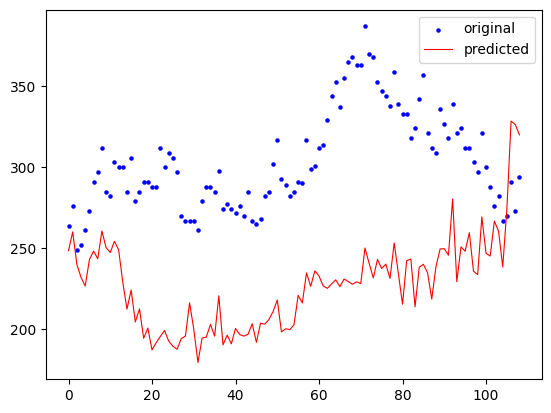

In [49]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()